<a href="https://colab.research.google.com/github/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-3/aulas/notebooks/aula_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 3

Essa aula faz parte do módulo 3 sobre séries temporais do bootcamp de DataSciance aplicada da Alura. Aqui vamos trabalhar com o fbprophet as mudanças de tendência. Os dados trabalhados durante todo o módulo serão dados públicos do [governo de São Paulo](https://www.seade.gov.br/coronavirus/) sobre os **casos de corona vírus**. Os dados já foram retirados do site e disponibilizados pelo github da Alura no dia 18/05/2021, [neste repositório](https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip).

Os dados usados nesta aula são somente da cidade de São Paulo, [deste repositório](https://github.com/matheus97eng/Bootcamp_Alura_2021/blob/main/modulo-3/aulas/data/out_dados_sp.csv).

In [ ]:
# obtendo os dados

import pandas as pd

url = 'https://github.com/matheus97eng/Bootcamp_Alura_2021/raw/main/modulo-3/aulas/data/out_dados_sp.csv'
dados_sp = pd.read_csv(url, index_col=0)
dados_sp.head()

,index,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem,taxa_de_crescimento_casos,taxa_de_crescimento_obitos,ano,media_movel_casos,media_movel_obitos
0,562,São Paulo,3550308,25,2,2020-02-25,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,NaN,NaN,2020,NaN,NaN
1,1207,São Paulo,3550308,26,2,2020-02-26,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,0.0,0.0,2020,NaN,NaN
2,1852,São Paulo,3550308,27,2,2020-02-27,1,0,"8,424841e-03","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,0.0,0.0,2020,NaN,NaN
3,2497,São Paulo,3550308,28,2,2020-02-28,2,1,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,1.0,0.0,2020,NaN,NaN
4,3142,São Paulo,3550308,29,2,2020-02-29,2,0,"1,684968e-02","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RM de São Paulo,10,Grande São Paulo,10,11869660,1853286,152111,<50,7.0,"-23,5329","-46,6395",9,-1.0,0.0,2020,NaN,NaN


In [ ]:
# vamos retirar a coluna "index":

dados_sp.drop('index', axis=1, inplace=True)

In [ ]:
# convertendo a coluna "datahora" em um time series:

dados_sp['datahora'] = pd.to_datetime(dados_sp['datahora'], format='%Y-%m-%d')
dados_sp['datahora']

0     2020-02-25
1     2020-02-26
2     2020-02-27
3     2020-02-28
4     2020-02-29
         ...    
438   2021-05-08
439   2021-05-09
440   2021-05-10
441   2021-05-11
442   2021-05-12
Name: datahora, Length: 443, dtype: datetime64[ns]

## Funções úteis (Desafio 12)

Muitos comandos serão repetidos durante as aulas, por isso vamos criar funções para economizar linhas de código:

+ `split_test_train` separa os dataframes df_train e df_test de acordo com 2 parâmetros, period, que conta quantos dias deixaremos para realizar o teste, e percent_test, recebe a porcentagem dos dados que queremos deixar para teste. Só é necessário informar um desses parâmetros. Se for informado a porcentagem, o período não será levado em conta.

+ `make_prediction` recebe um modelo instanciado do fbprophet, além dos dataframes de teste e treino. Ele faz o fit do modelo e e retorna o daframe de previsão (`forecast`) de acordo com os dias que foram passados para o dataframe de teste.

In [ ]:
from fbprophet import Prophet

def split_train_test(data, ds='datahora', y='casos_novos', period=30, percent_test=None):

  df_test = pd.DataFrame()
  df_train = pd.DataFrame()
  
  if percent_test == None:
    x = data.shape[0] - period
  else:
    x = int(data.shape[0] * (1-percent_test))

  df_train['ds'] = data[ds][:x]
  df_train['y'] = data[y][:x]
  df_test['ds'] = data[ds][x:]
  df_test['y'] = data[y][x:]

  return df_train, df_test

def make_prediction(model, df_train, df_test, cap=None):

  model.fit(df_train)
  df_future = model.make_future_dataframe(periods=df_test.shape[0])
  if cap != None:
    df_future['cap'] = cap
  forecast = model.predict(df_future)
  return forecast



## Changepoints no fbprophet

O fbprophet é flexível com relação a changepoints, pontos onde a tendência geral da curva do modelo é alterada. Podemos escolher o número de changepoints do nosso modelo, quais serão e também plotá-los junto com o gráfico de previsão gerado pelo prophet. Para entender melhor o papel desses changepoints, vamos primeiro visualizá-los no gráfico. Para isso precisaremos do método `add_changepoints_to_plot` de `fbprophet.plot`. Ele precisa receber como parâmetros os eixos do plot gerado por `model.plot`, o modelo instanciado e o dataframe que contém os dados de previsão feitos pelo prophet.

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


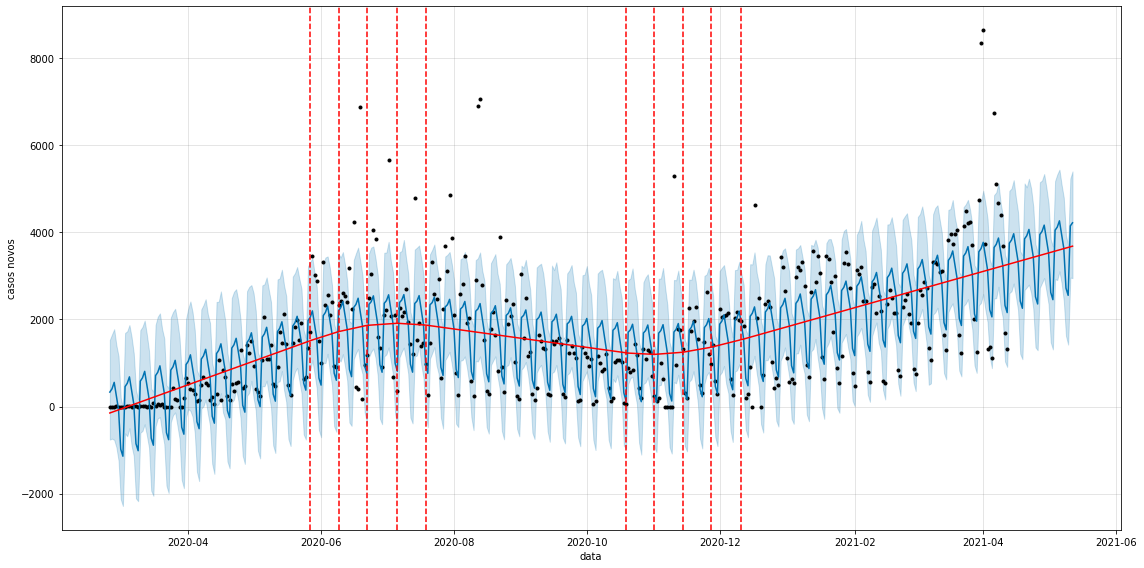

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt

df_train, df_test = split_train_test(dados_sp)
model = Prophet()
predict = make_prediction(model, df_train, df_test)

# plotando
fig = model.plot(predict, xlabel='data', ylabel='casos novos', figsize=(16,8))
add_changepoints_to_plot(fig.gca(), model, predict)     # a função .gca() retira os eixos da figura fig
plt.show()

A linha vermelha no plot é a tendência geral da curva, um dos efeitos somados para gerar a curva azul escura. De tracejado vermelho, conseguimos identificar os changepoints determinados pelo prophet, que são pontos aonde a **curva de tendência geral muda de direção**. 

O que acontece é que o prophet tem um parâmetro `growth` quando escolhemos o modelo que determina o tipo de crescimento da curva no modelo. Por padrão, o prophet faz com que essa tendência de crescimento seja sempre linear, ou seja, **a curva de tendência geral é formada somente por linhas retas**. Se há um **changepoint**, uma outra reta com diferente inclinação é adicionada à curva, para se conformar ao padrão que os dados informam.

Outro possível valor para `growth` é "logistic", ou seja, um crescimento logístico, caracterizado pelo crescimento exponencial no início e, ao final da curva, uma estabilização para uma reta horizontal.

Agora, vamos começar a testar diferentes parâmetros da classe Prophet, começando com `n_changepoints`, o número máximo de changepoints que a ferramenta gerará.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


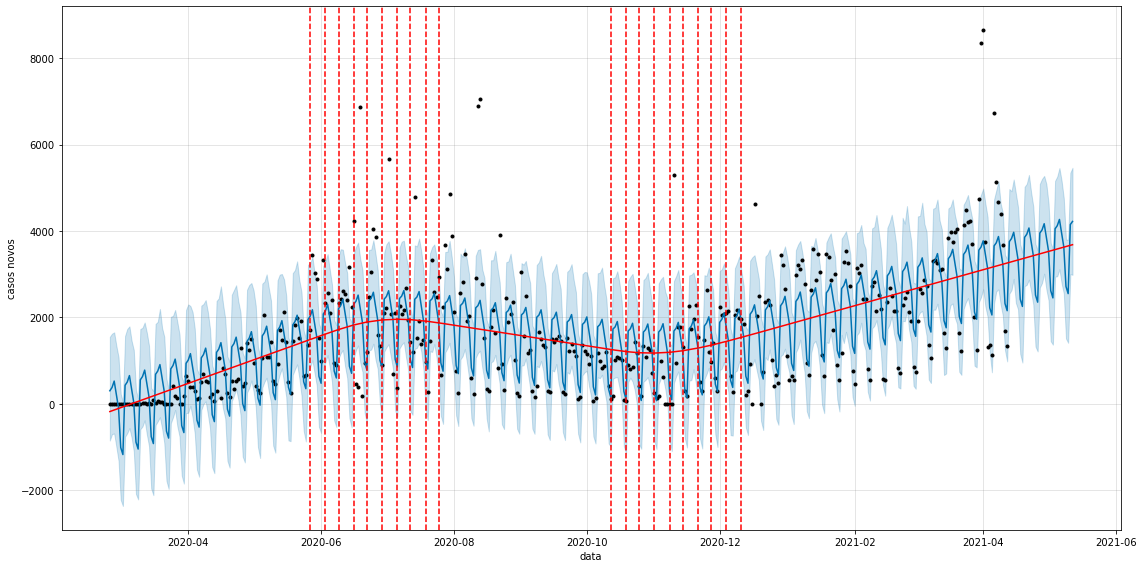

In [ ]:
df_train, df_test = split_train_test(dados_sp)
model = Prophet(n_changepoints=50)
predict = make_prediction(model, df_train, df_test)

# plotando
fig = model.plot(predict, xlabel='data', ylabel='casos novos', figsize=(16,8))
add_changepoints_to_plot(fig.gca(), model, predict)     # a função .gca() retira os eixos da figura fig
plt.show()

Agora que aumentamos o número de changepoints, a curva de tendência se torna um pouco mais suave, mas isso não parece ter afetado muito o resultado final.

Testando agora outro parâmetro, `changepoints_prior_scale`, que interfere na sensibilidade do pandas em identificar changepoints. Quanto maior esse parâmetro, mais flexível será a curva de previsão para se ajustar aos dados. Isso é ótimo para manter os dados de treino dentro do intervalo de confiança, mas ruim para fazer previsões, por causa do overfit. De maneira bem simplista, o overfit acontece quando eu faço o modelo se ajustar demais aos dados que possuo e isso faz com que pequenas mudanças nos dados alterem ainda mais a minha previsão, a ponto dela não ser muito fiel à tendência geral dos dados. 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


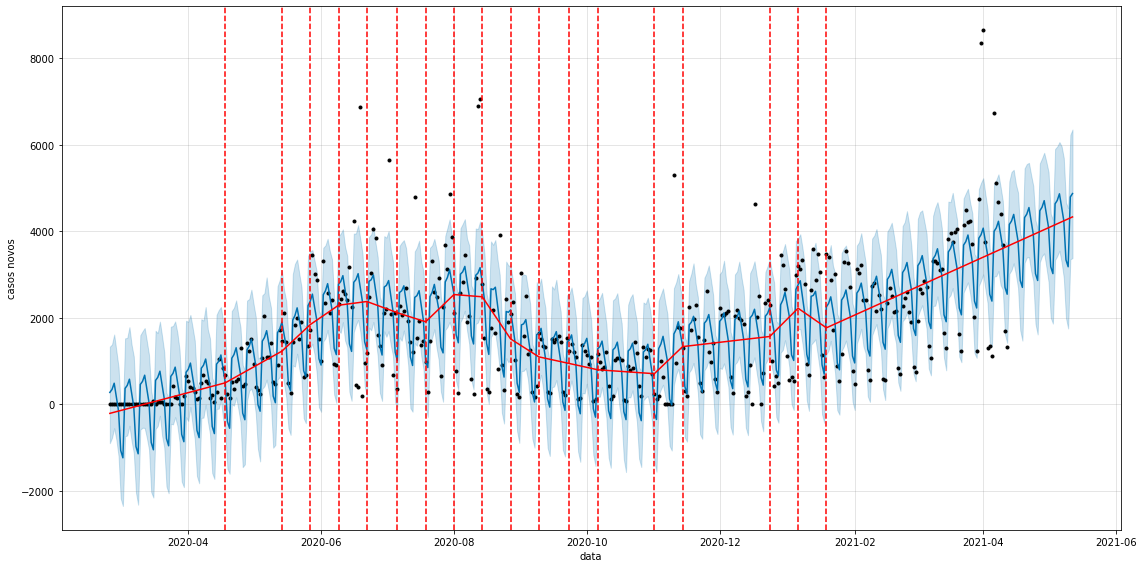

In [ ]:
df_train, df_test = split_train_test(dados_sp)
model = Prophet(n_changepoints=25, changepoint_prior_scale=10.)
predict = make_prediction(model, df_train, df_test)

# plotando
fig = model.plot(predict, xlabel='data', ylabel='casos novos', figsize=(16,8))
add_changepoints_to_plot(fig.gca(), model, predict)     # a função .gca() retira os eixos da figura fig
plt.show()

perceba que nos meses de Junho a Agosto a curva de tendência sobe bastante para se ajustar a alguns valores altos dos dados nesse período.

Vamos testar agora um valor baixo de `changepoints_prior_scale`. Isso fará o fbprophet analisar os dados quase de ponto a ponto, o que reduz a flexibilidade em tendências

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


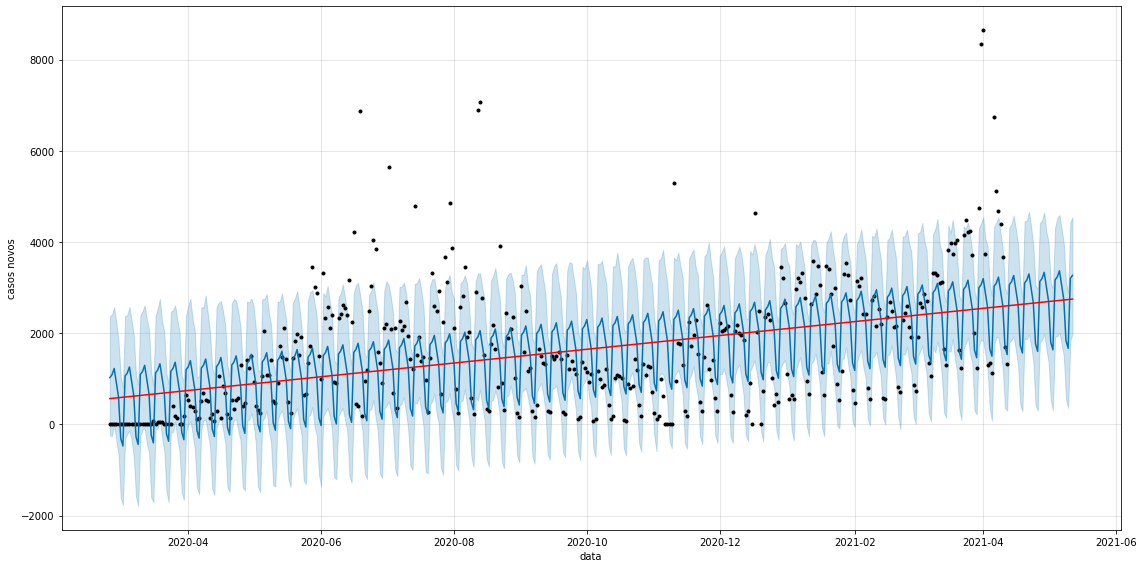

In [ ]:
df_train, df_test = split_train_test(dados_sp)
model = Prophet(n_changepoints=100, changepoint_prior_scale=0.0005)
predict = make_prediction(model, df_train, df_test)

# plotando
fig = model.plot(predict, xlabel='data', ylabel='casos novos', figsize=(16,8))
add_changepoints_to_plot(fig.gca(), model, predict)     # a função .gca() retira os eixos da figura fig
plt.show()

Além desses parâmetros, temos a opção de adicionar "manualmente" quais serão os changepoints com o parâmetro `changepoints`, que recebe uma lista de datas. Vamos testar por exemplo com a data de final de ano "2020-12-31"

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


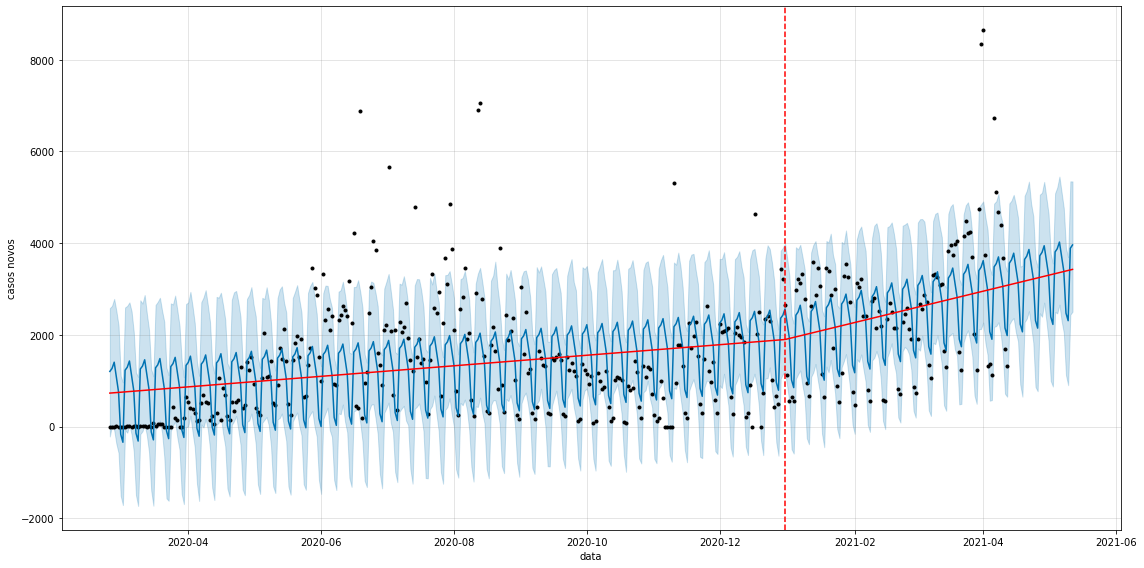

In [ ]:
df_train, df_test = split_train_test(dados_sp)
model = Prophet(changepoints=['2020-12-31'])
predict = make_prediction(model, df_train, df_test)

# plotando
fig = model.plot(predict, xlabel='data', ylabel='casos novos', figsize=(16,8))
add_changepoints_to_plot(fig.gca(), model, predict)     # a função .gca() retira os eixos da figura fig
plt.show()

## Desafios:

Desafio 11: Identificar potenciais changepoints.

Desafio 12: Desenvolver uma função roda o modelo automaticamente.

Desafio Extra: Realizar o ajuste do modelo para os dados de casos acumulados, utilizando um crescimento logístico ao invés do linear.

### Desafio 11: Identificar potenciais changepoints.

Inicialmente, vamos tentar identificar changepoints analisando o gráfico de média móvel do número de casos.

#### Indentificando changepoints

##### Olhando para a média móvel

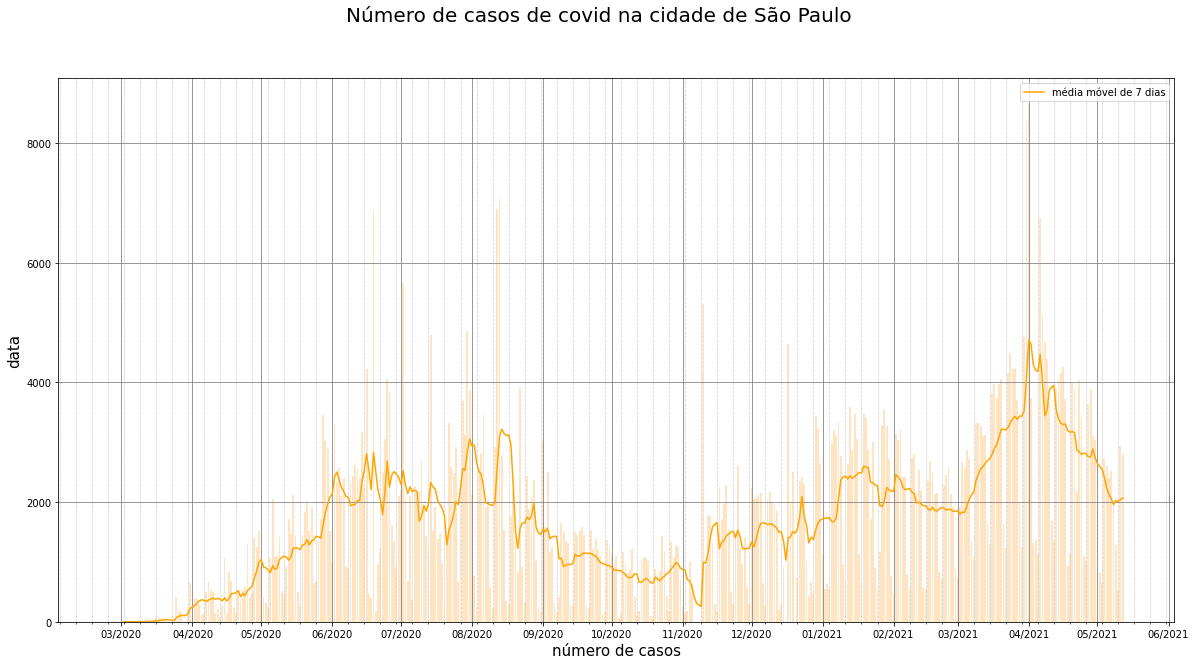

In [ ]:
import seaborn as sns
import matplotlib.dates as mdates

plt.figure(figsize=(20,10))
plt.bar(x='datahora', height='casos_novos', data=dados_sp, color='bisque')
ax = sns.lineplot(x='datahora', y='media_movel_casos', data=dados_sp, label='média móvel de 7 dias', color='orange')

plt.suptitle('Número de casos de covid na cidade de São Paulo', size=20)
plt.grid(which='major', color='gray')
plt.grid(which='minor', linestyle='--', color='lightgray')
plt.xlabel('número de casos', size=15)
plt.ylabel('data', size=15)

# formatação de datetime para o eixo x
major_fmt = mdates.MonthLocator()    
ax.xaxis.set_major_locator(major_fmt)
minor_fmt = mdates.DayLocator(interval=7)
ax.xaxis.set_minor_locator(minor_fmt)
MonthYearFmt = mdates.DateFormatter('%m/%Y')
ax.xaxis.set_major_formatter(MonthYearFmt)

vamos tentar ums média móvel de mais dias, para observarmos melhor a tendência geral

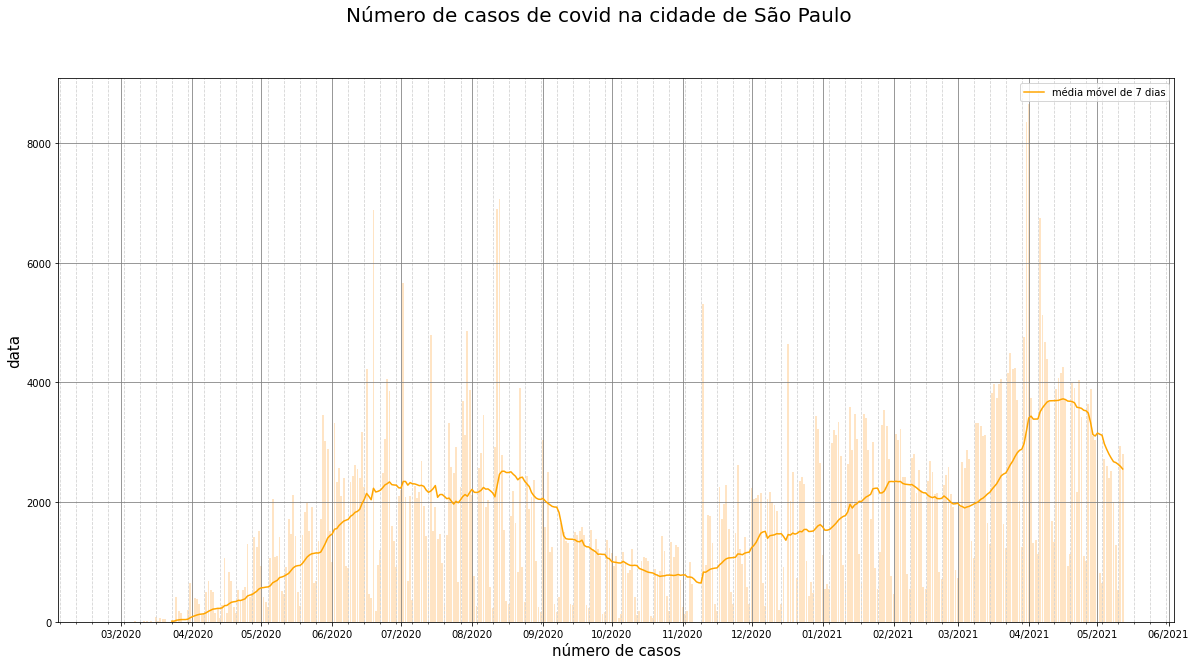

In [ ]:
dados_sp['media_movel_28_casos'] = dados_sp['casos_novos'].rolling(window=28, center=False).mean()

plt.figure(figsize=(20,10))
plt.bar(x='datahora', height='casos_novos', data=dados_sp, color='bisque')
ax = sns.lineplot(x='datahora', y='media_movel_28_casos', data=dados_sp, label='média móvel de 7 dias', color='orange')

plt.suptitle('Número de casos de covid na cidade de São Paulo', size=20)
plt.grid(which='major', color='gray')
plt.grid(which='minor', linestyle='--', color='lightgray')
plt.xlabel('número de casos', size=15)
plt.ylabel('data', size=15)

# formatação de datetime para o eixo x
major_fmt = mdates.MonthLocator()    
ax.xaxis.set_major_locator(major_fmt)
minor_fmt = mdates.DayLocator(interval=7)
ax.xaxis.set_minor_locator(minor_fmt)
MonthYearFmt = mdates.DateFormatter('%m/%Y')
ax.xaxis.set_major_formatter(MonthYearFmt)

Vamos agora aproximar esse gráfico para visualizar melhor aonde ocorreram os change points.

In [ ]:
for mes in range(6,11):
  print(mes)
ano = 2020

ano == 2020 and mes in range(6,11)

6
7
8
9
10


True

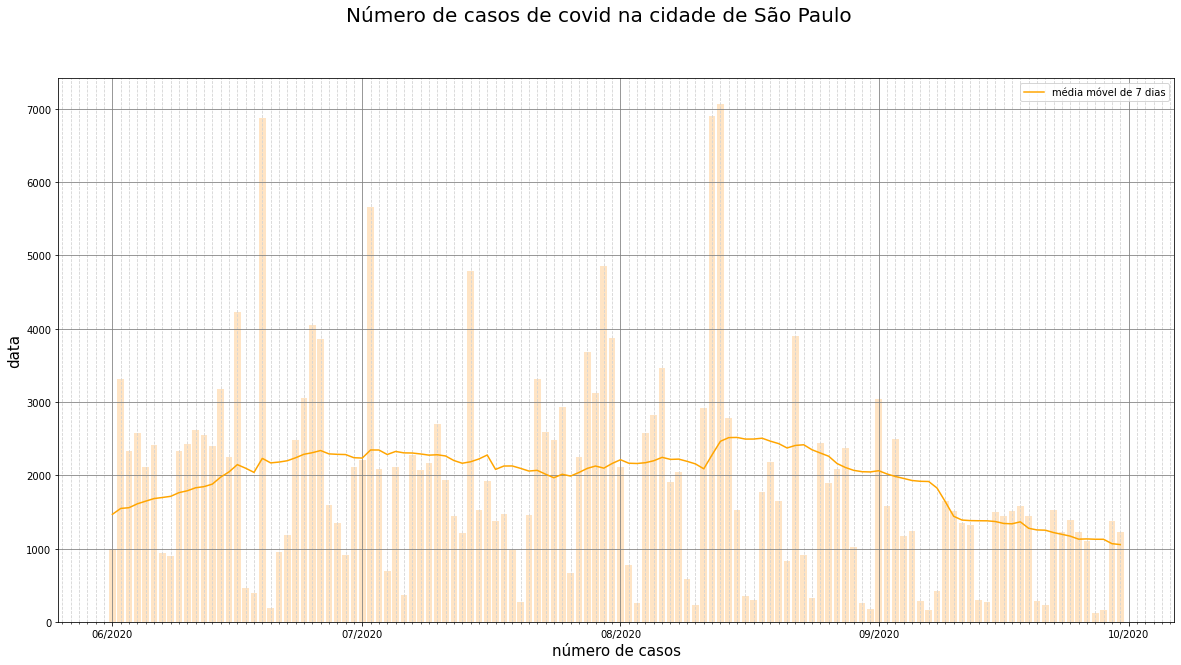

In [ ]:
dados_query = dados_sp.query('ano == 2020 and mes > 5 and mes < 10')

plt.figure(figsize=(20,10))
plt.bar(x='datahora', height='casos_novos', data=dados_query, color='bisque')
ax = sns.lineplot(x='datahora', y='media_movel_28_casos', data=dados_query, label='média móvel de 7 dias', color='orange')

plt.suptitle('Número de casos de covid na cidade de São Paulo', size=20)
plt.grid(which='major', color='gray')
plt.grid(which='minor', linestyle='--', color='lightgray')
plt.xlabel('número de casos', size=15)
plt.ylabel('data', size=15)

# formatação de datetime para o eixo x
major_fmt = mdates.MonthLocator()    
ax.xaxis.set_major_locator(major_fmt)
minor_fmt = mdates.DayLocator()
ax.xaxis.set_minor_locator(minor_fmt)
MonthYearFmt = mdates.DateFormatter('%m/%Y')
ax.xaxis.set_major_formatter(MonthYearFmt)

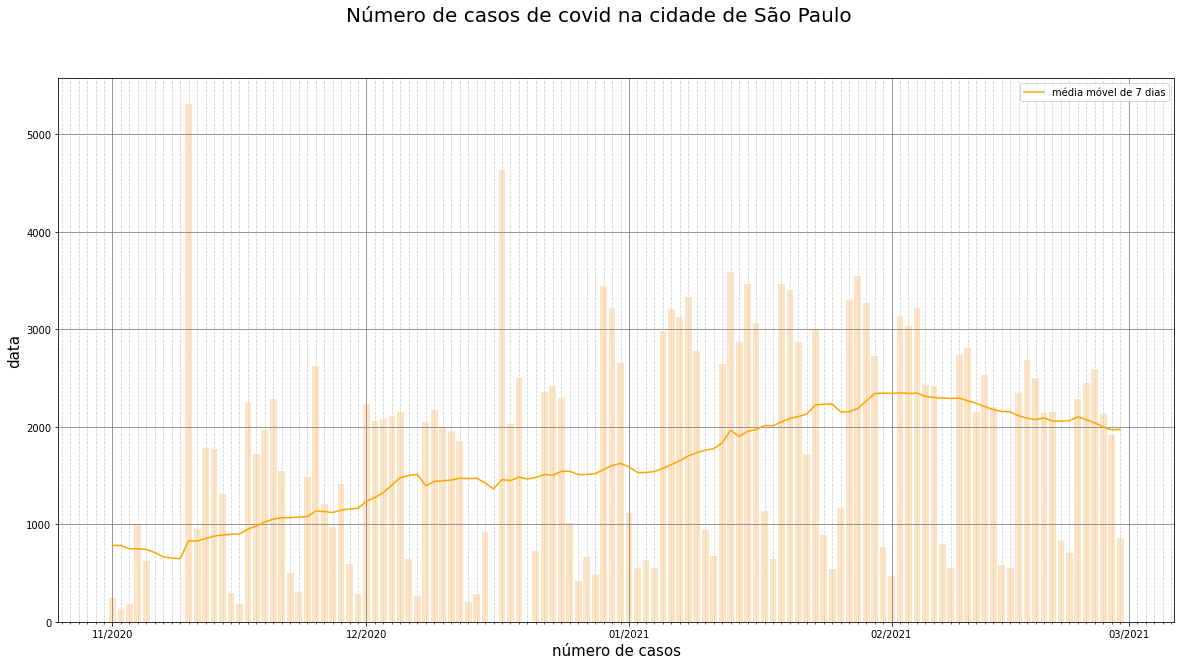

In [ ]:
dados_query = dados_sp.query('(ano == 2020 and mes > 10) or (ano == 2021 and mes > 0 and mes < 3)')

plt.figure(figsize=(20,10))
plt.bar(x='datahora', height='casos_novos', data=dados_query, color='bisque')
ax = sns.lineplot(x='datahora', y='media_movel_28_casos', data=dados_query, label='média móvel de 7 dias', color='orange')

plt.suptitle('Número de casos de covid na cidade de São Paulo', size=20)
plt.grid(which='major', color='gray')
plt.grid(which='minor', linestyle='--', color='lightgray')
plt.xlabel('número de casos', size=15)
plt.ylabel('data', size=15)

# formatação de datetime para o eixo x
major_fmt = mdates.MonthLocator()    
ax.xaxis.set_major_locator(major_fmt)
minor_fmt = mdates.DayLocator()
ax.xaxis.set_minor_locator(minor_fmt)
MonthYearFmt = mdates.DateFormatter('%m/%Y')
ax.xaxis.set_major_formatter(MonthYearFmt)

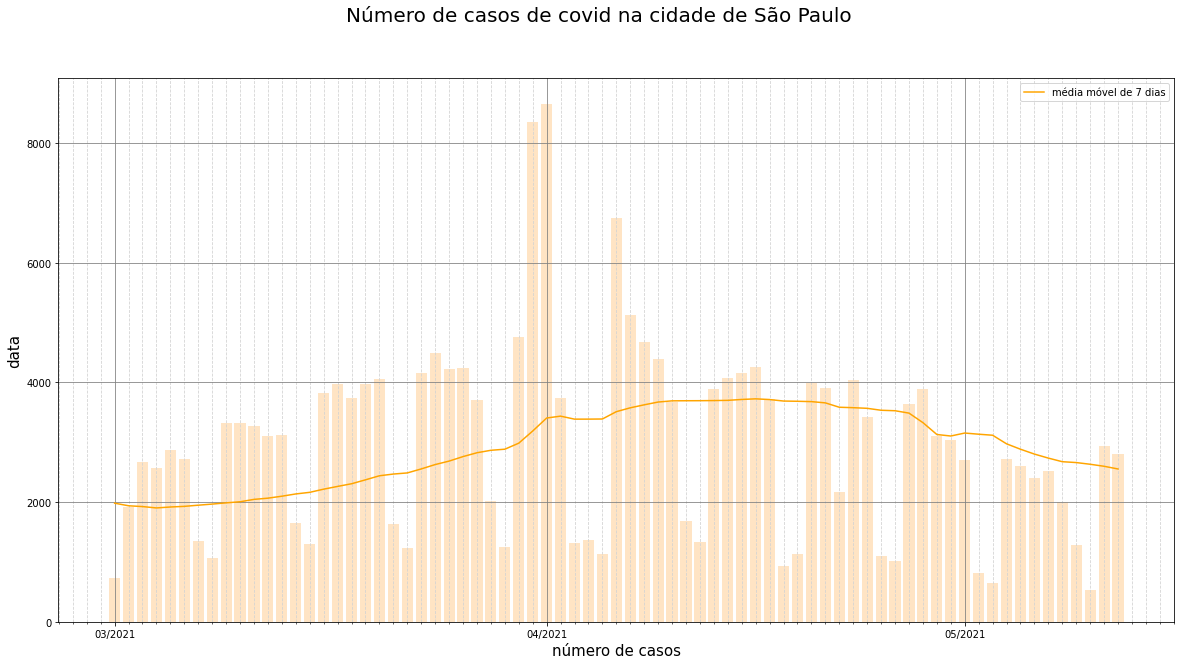

In [ ]:
dados_query = dados_sp.query('ano == 2021 and mes > 2')

plt.figure(figsize=(20,10))
plt.bar(x='datahora', height='casos_novos', data=dados_query, color='bisque')
ax = sns.lineplot(x='datahora', y='media_movel_28_casos', data=dados_query, label='média móvel de 7 dias', color='orange')

plt.suptitle('Número de casos de covid na cidade de São Paulo', size=20)
plt.grid(which='major', color='gray')
plt.grid(which='minor', linestyle='--', color='lightgray')
plt.xlabel('número de casos', size=15)
plt.ylabel('data', size=15)

# formatação de datetime para o eixo x
major_fmt = mdates.MonthLocator()    
ax.xaxis.set_major_locator(major_fmt)
minor_fmt = mdates.DayLocator()
ax.xaxis.set_minor_locator(minor_fmt)
MonthYearFmt = mdates.DateFormatter('%m/%Y')
ax.xaxis.set_major_formatter(MonthYearFmt)

26/06/2020
24/07/2020
11/08/2020
09/11/2020
01/02/2021
04/03/2021
09/04/2021
27/04/2021

##### testando:

Os changepoints não podem conter datas fora do dataframe de treino.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


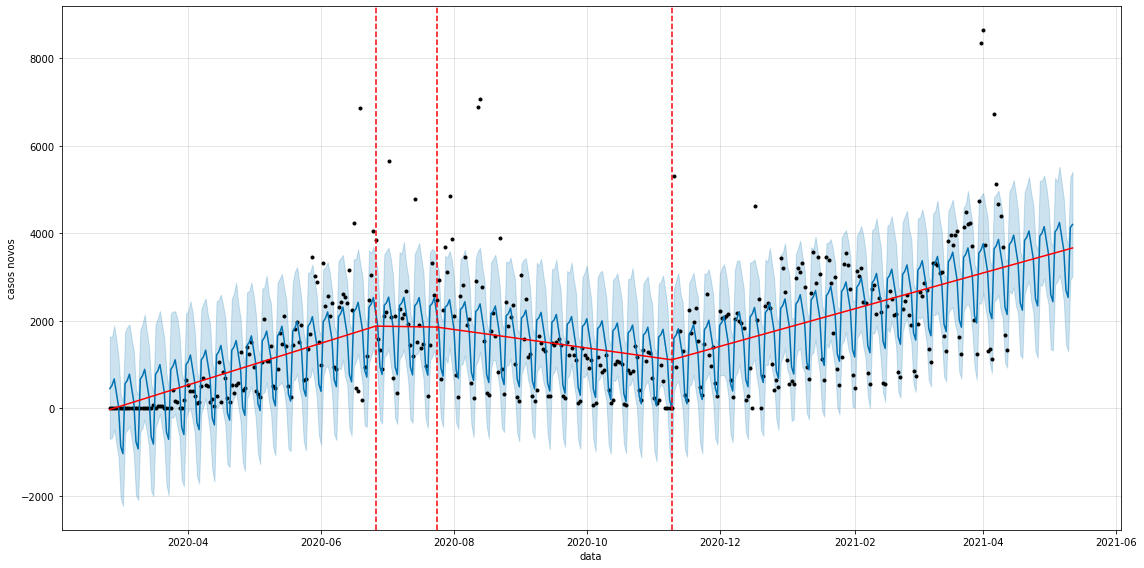

In [ ]:
changepoints = ['2020-06-26',
                '2020-07-24',
                '2020-08-11',
                '2020-11-09', 
                '2021-02-01',
                '2021-03-04',
                '2021-04-09'
                ]

df_train, df_test = split_train_test(dados_sp)
model = Prophet(changepoints=changepoints)
predict = make_prediction(model, df_train, df_test)

# plotando
fig = model.plot(predict, xlabel='data', ylabel='casos novos', figsize=(16,8))
add_changepoints_to_plot(fig.gca(), model, predict)     # a função .gca() retira os eixos da figura fig
plt.show()

##### uma análise mais automática

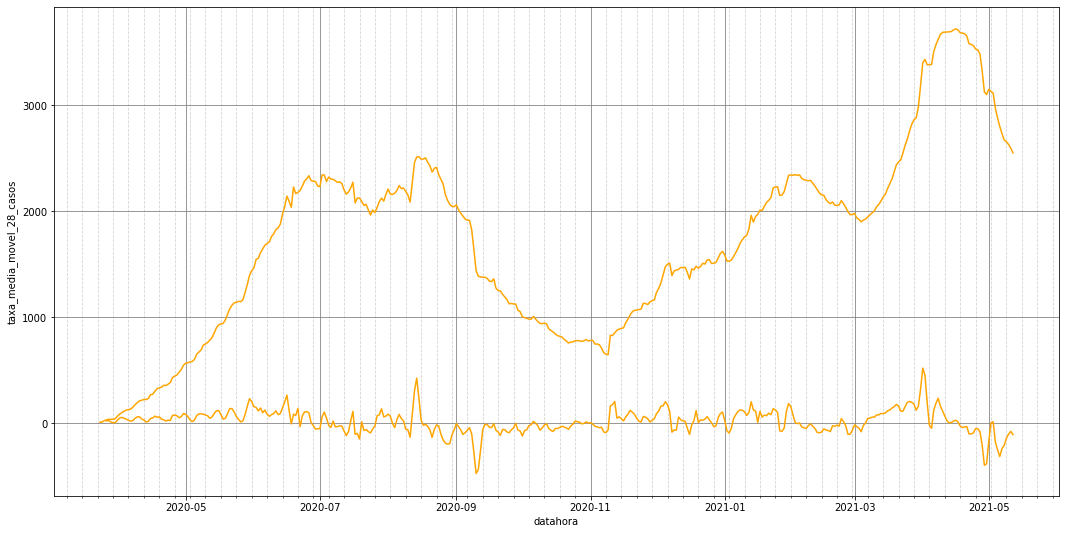

In [ ]:
dados_sp['taxa_media_movel_28_casos'] = dados_sp['media_movel_28_casos'].diff(periods=3)

plt.figure(figsize=(18,9))
ax = sns.lineplot(x='datahora', y='taxa_media_movel_28_casos', data=dados_sp, color='orange')
sns.lineplot(x='datahora', y='media_movel_28_casos', data=dados_sp, color='orange')

minor_fmt = mdates.DayLocator(interval=7)
ax.xaxis.set_minor_locator(minor_fmt)
plt.grid(which='major', color='gray')
plt.grid(which='minor', linestyle='--', color='lightgray')

### Desafio 12: Desenvolver uma função roda o modelo automaticamente.

Esse desafio foi cumprido no início do notebook

### Desafio Extra: Realizar o ajuste do modelo para os dados de casos acumulados, utilizando um crescimento logístico ao invés do linear.

In [ ]:
dados_sp['casos'].max()*1.1

816891.9

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


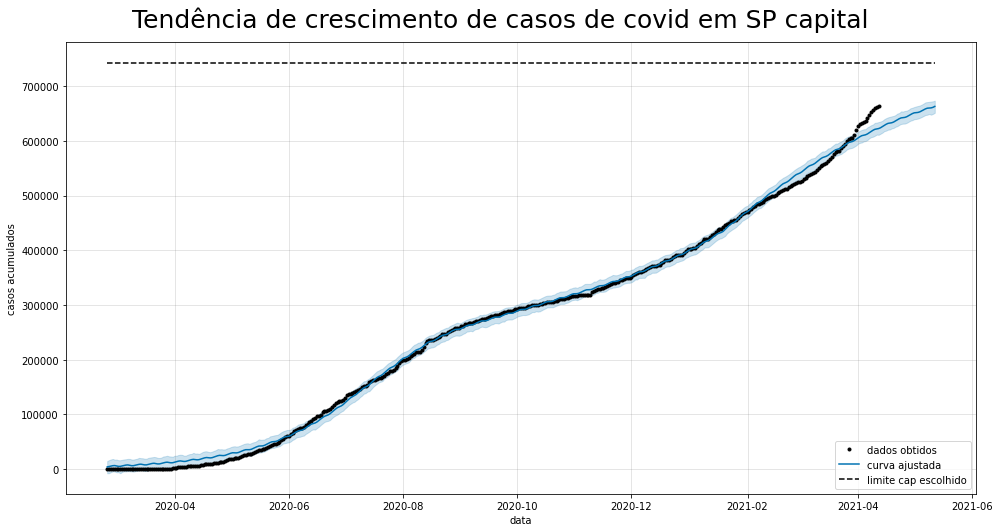

In [ ]:
df_train, df_test = split_train_test(dados_sp, y='casos')
df_train['cap'] = dados_sp['casos'].max()*1
#df_test['cap'] = df_test['y'].max()*1
model = Prophet(growth='logistic') 
predict = make_prediction(model, df_train, df_test, cap=dados_sp['casos'].max()*1)

fig = model_logistic.plot(predict, xlabel='data', ylabel='casos acumulados', figsize=(14,7))
plt.suptitle('Tendência de crescimento de casos de covid em SP capital', size=25, y=1.05)
plt.legend(labels=['dados obtidos', 'curva ajustada', 'limite cap escolhido'])
plt.show()